# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 0000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

---

# План работ

- [Шаг 1. Загрузка и подготовка данных](#section_1)

- [Шаг 2. Обучение и проверка модели](#section_2)

- [Шаг 3. Подготовка к расчёту прибыли](#section_3)

- [Шаг 4. Расчёт прибыли и рисков](#section_4)

- [Шаг 5. Общий вывод](#section_5)

- [Шаг 6. Чек-лист готовности проекта](#section_6)

---

<a id='section_1'></a>

## Загрузка и подготовка данных

### Установка и импортирование библиотек

In [1]:
#Установка библиотек:
!pip install -U scikit-learn
!pip install phik

In [2]:
#Импорт библиотек:

#Библиотеки для работы с табличными данными и массивами:
import pandas as pd
import numpy as np

#Библиотеки для графической иллюстрации:
import matplotlib.pyplot as plt
import seaborn as sns

#Библиотека для стат.анализа:
from scipy import stats as st

#Библиотеки для корреляционного анализа:
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

#Инструменты для создания пайплайнов:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Библиотеки для масштабирования данных:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Модели МО:
from sklearn.linear_model import LinearRegression, Ridge

#Библиотеки для создания выборок:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#Библиотеки для метрик:
from sklearn.metrics import root_mean_squared_error

### Выгрузка данных и первичный осмотр

In [3]:
#Считываем и распаковываем исходные данные, представленные в формате CSV:
#Считываем с сети:
try:
    #Тренировочная выборка:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    
    #Входные признаки тестовой выборки:
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    
    #Целевой признак тестовой выборки:
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
        
#В случае изменения ссылки или отсутсвия сети:
except:
    
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    
    data_0 = pd.read_csv('/datasets/geo_data_1.csv')
    
    data_0 = pd.read_csv('/datasets/geo_data_2.csv')
        
#Используем специальную команду отображения таблиц, для наглядного просмотра всех данных:    
pd.set_option('display.max_columns', None)

In [4]:
#Создадим список, в который положим все исходные датафреймы:
all_data = [data_0, data_1, data_2]

#С помощью цикла просмотрим все данные о каждой таблице:
for data in all_data:    
    display(data.head(10))
    print()
    data.info()
    print()
    print('-'*125)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

-----------------------------------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

-----------------------------------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

-----------------------------------------------------------------------------------------------------------------------------


In [5]:
#Проверка на наличие дубликатов:
for data in all_data:
    print(data.duplicated().sum())
    print()

0

0

0



**По предварительному анализу выгруженных данных можно сделать выводы:**

> Каждый датасет, из трёх представленных, имеет **5 столбцов** и **100000 строк**

**Имена столбцов в каждом датасете корректны и совпадают:**

- ***id*** — уникальный идентификатор скважины
- ***f0, f1, f2*** — три признака точек (неважно, что они означают, но сами признаки значимы)
- ***product*** — объём запасов в скважине (тыс. баррелей)

> Все типы данных соответсвуют всем значениям типов в столбцах

> Дубликатов в данных нет

> Пропусков в данных нет

### Исследовательский анализ

#### Анализ входных признаков

Сначала проведем анализ всех входных признаков по всем датасетам. Для удобства построения создадим функцию:

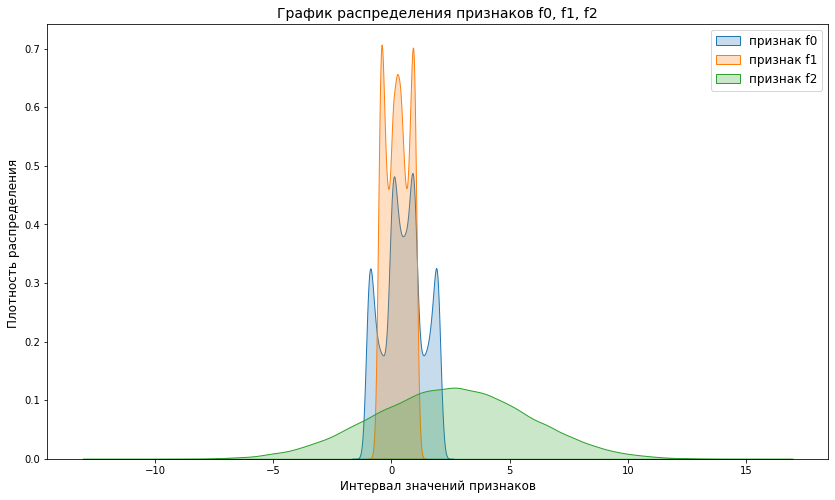

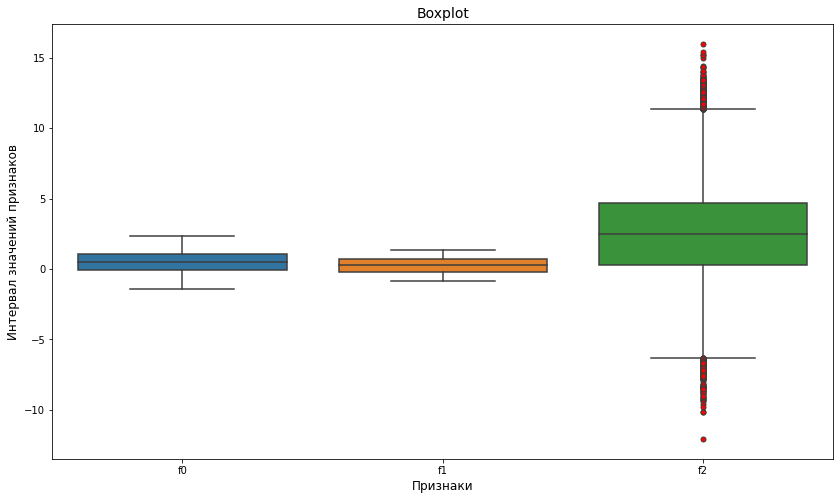

In [6]:
#Определяем функцию:
def graph(data):
    
    #Построение графиков распределения для входных признаков f0, f1, f2:
    plt.figure(figsize=(14,8))
    sns.kdeplot(data['f0'], shade=True, label='признак f0')
    sns.kdeplot(data['f1'], shade=True, label='признак f1')
    sns.kdeplot(data['f2'], shade=True, label='признак f2')
    plt.title(f'График распределения признаков f0, f1, f2', fontsize=14)
    plt.xlabel('Интервал значений признаков', fontsize=12)
    plt.ylabel('Плотность распределения ', fontsize=12)
    plt.legend(loc='upper right', fontsize=12)
    plt.show()
    
    #Построения ящиков с усами:
    plt.figure(figsize=(14,8))
    sns.boxplot(data=data.loc[:,'f0':'f2'], flierprops=dict(marker='o', markerfacecolor='red', markersize=5))
    plt.xlabel('Признаки', fontsize=12)
    plt.ylabel('Интервал значений признаков', fontsize=12)
    plt.title('Boxplot', fontsize=14)

#вызываем функцию для data_0:
graph(data_0)

> Все признаки лежат в интервале допустимых значений **(аномалий - нет)**

> Признак ***f2*** - имеет выбросы (избавляться от данных выбросов мы не будем, аргументируя это тем, что данные лежат в допустимом диапозоне)

> Признак ***f2*** - имеет нормальное распределение

> Признаки ***f0, f1*** - лежат в допустимом интервале и не имеют выбросов, но их распределение назвать нормальным - трудно. Данные распределения имеют множество пиков, но маленький разброс, по сравнению с признаком ***f2***

Теперь рассмотрим теже признаки для второго датасета ***data_1***:

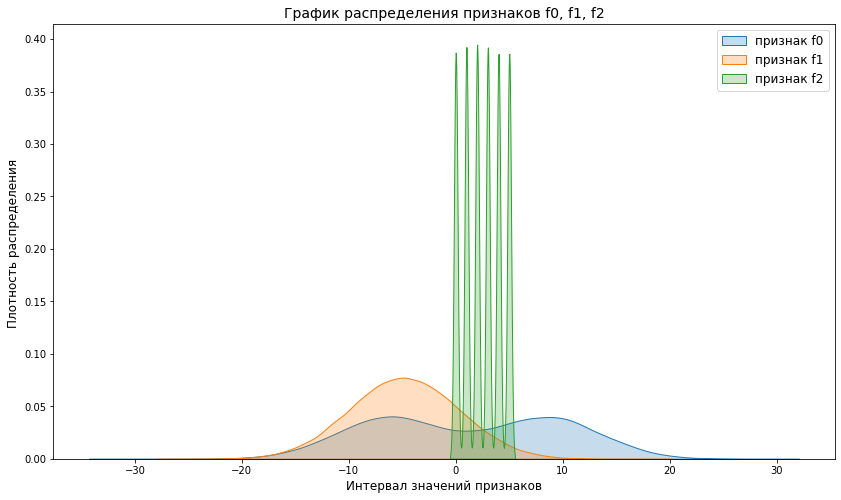

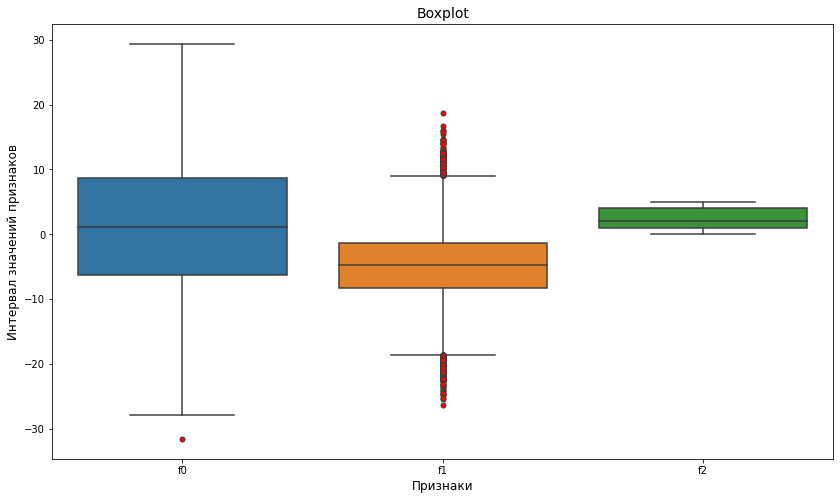

In [7]:
#вызываем функцию для data_1:
graph(data_1)

> Все признаки лежат в интервале допустимых значений **(аномалий - нет)**

> Признаки ***f0,f1*** - имеют выбросы (избавляться от данных выбросов мы не будем, аргументируя это тем, что данные лежат в допустимом диапозоне)

> Признак ***f1*** - имеет нормальное распределение

> Признак ***f0*** - имеет две выпуклости, схоже с нормальным распределением с двумя горбами

> Признак ***f2*** - имеет маленький разброс значений, и множество пиков

Теперь рассмотрим теже признаки для третьего датасета ***data_2***:

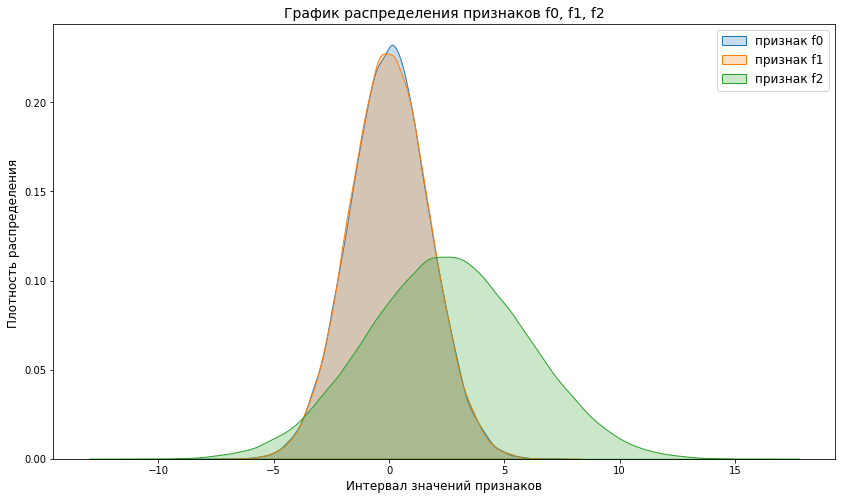

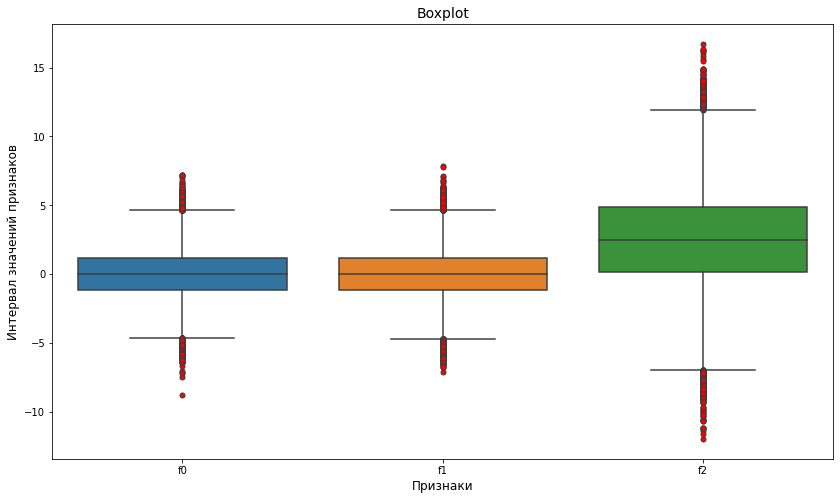

In [8]:
#вызываем функцию для data_1:
graph(data_2)

> Все признаки имеют нормальное распределение

> Все признаки имееют выбросы, но аномальные значения - отсутствуют

> Все признаки лежат в допустимых интервалах

> Наибольший разброс имеет признак ***f2***

#### Анализ целевого признака

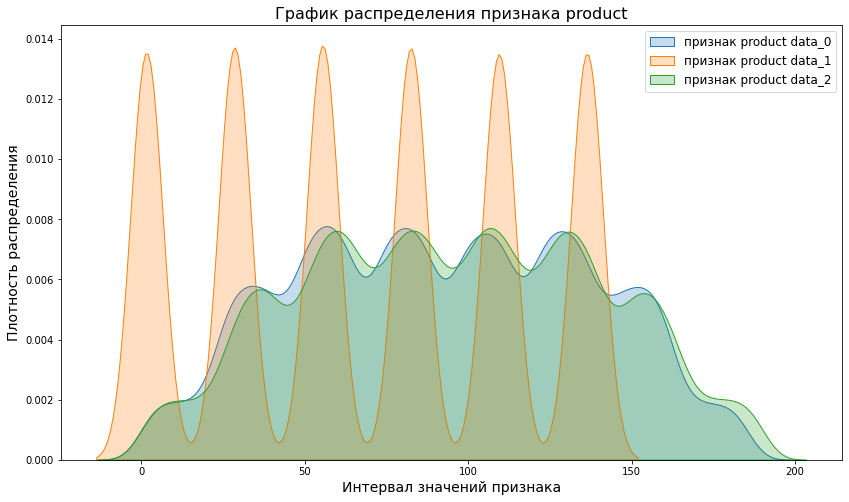

In [9]:
#Построение графиков распределения для входных признаков f0, f1, f2:
plt.figure(figsize=(14,8))
sns.kdeplot(data_0['product'], shade=True, label='признак product data_0')
sns.kdeplot(data_1['product'], shade=True, label='признак product data_1')
sns.kdeplot(data_2['product'], shade=True, label='признак product data_2')
plt.title(f'График распределения признака product', fontsize=16)
plt.xlabel('Интервал значений признака', fontsize=14)
plt.ylabel('Плотность распределения', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.show() 

> Данные лежат в допустимом диапозоне (аномалий - нет)

> Признаки для первого и второго датасета почти идентично распределены, и схожи с нормальным распределением

> Признак ***product*** второго датасета имеет значения, которые распределены дискретно

**Подводя итоги исследовательского анализа данных, можно сказать, что большеснтво данных имеет нормальное распределение и лежит в допустимых диапозонах. Есть признаки как входные, так и целевые, распределение которых сложно назвать нормальным, но удалять их мы не будем, т.к. они понадобятся для обучения модели (при постановке задачи, было сказано, что входные признаки *f0,f1,f2* - значимы). Также в данных нет аномалий, но наблюдаются выбросы, это также необходимо учесть для дальнейшего анализа.**

### Корреляционный анализ

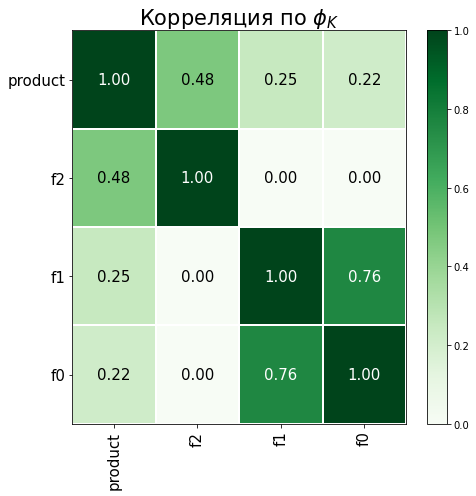

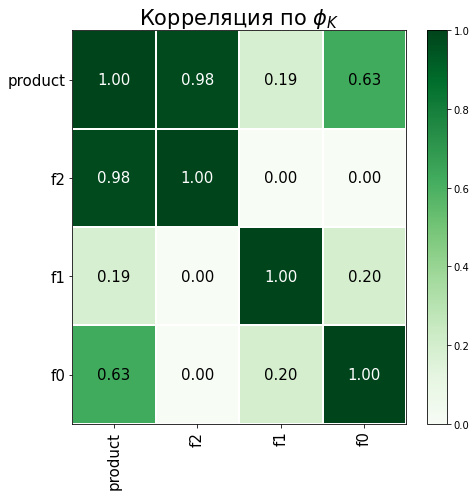

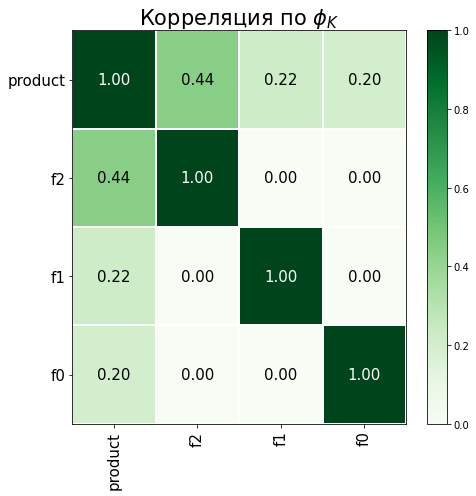

In [10]:
#Создаем список непрерывных переменных:
interval_cols = ['f0', 'f1', 'f2', 'product']

#Строим матрицу корреляции Phik для всех датасетов в цикле:
for data in all_data:
    
    #Считаем корреляции данных:
    phik_overview = phik_matrix(data.drop('id', axis=1), interval_cols=interval_cols)

    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'Корреляция по $\phi_K$',
        fontsize_factor=1.5,
        figsize=(7, 7)
    )

> **Утечка целового признака** - наблюдается во втором датасете между целевым признаком и входным ***f2*** и составляет **0.98**

> Мультиколлинеарности не наблюдается

Мы обнаружили утечку целового признака, требуется удалить данный входной признак, но по условию задачи мы не можем этого сделать, потому что признаки, как было сказано ранее, **значимы**. Поэтому мы используем ***L2-регуляризацию***, при обучении модели, которая уменьшит влияние входного признака ***f2***, наложив штраф на большие коэффициенты, не обнуляя их.

<a id='section_2'></a>

## Обучение и проверка модели

### Создание пайплайна

In [11]:
#Список для кодирования количественных перменных:
num_columns = ['f0', 'f1', 'f2']

data_preprocessor = ColumnTransformer(
    [     
        ('num', StandardScaler(), num_columns)    
    ], 
    remainder =  'passthrough'
)

#Создаем пайплайн, в котором будем перебирать методы масштабирования модели:
pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

#Вызовем пайплайн и посмотрим что получилось:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

### Обучение модели LinearRegression для data_0

In [12]:
#Константы:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#Отделяем входные признаки от целевого

#Входные признаки:
X = data_0.drop(['id', 'product'], axis=1)
#Целевой признак:
y = data_0['product']

#Создаем тренеровочную и тестовую выборки (стратифицируем по целевому признаку):
X_train, X_valid, y_train, y_valid_0 = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE,)

#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [  
    {'models': [LinearRegression()],          
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

#Поиск гиперпараметров:  
randomized_search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    cv=5,
    random_state=RANDOM_STATE,
    n_iter=3,
    n_jobs=-1
)

#Обучаем модель:
randomized_search.fit(X_train, y_train)

#Предсказываем значение целевого признака по валидационной выборке:
y_pred_0 = randomized_search.predict(X_valid)

#Считаем метрику RMSE:
rmse_0 = root_mean_squared_error(y_valid_0, y_pred_0)

#Сразу посмотрим значение этой метрики:
rmse_0

37.75660035026169

In [13]:
y_pred_0.mean()

92.39879990657768

Значение метрики ***RMSE*** говорит о том, насколько в среднем модель ошибается в предсказаниях:

> ***product*** - объём запасов в скважине (тыс. баррелей)

> В среднем модель ошибается на **37-38** тыс. баррелей нефти при предсказании значений объема в скважине

> Среднее значение по столбцу предсказаний равно **92.39**

### Обучение модели LinearRegression для data_1

> При обучении второй модели мы обусловились, что будем использовать **L2-регуляризацию** в связи с **мультиколлинеарностью**:

Для этого используем ***модель Ridge()*** - она является моделью линейной регрессии с регуляризацией  ***L2*** и параметром ***alpha***, данный параметр определяет силу регуляризации

In [14]:
#Отделяем входные признаки от целевого

#Входные признаки:
X = data_1.drop(['id', 'product'], axis=1)
#Целевой признак:
y = data_1['product']

#Создаем тренеровочную и тестовую выборки (стратифицируем по целевому признаку):
X_train, X_valid, y_train, y_valid_1 = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE,)

#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [  
    {'models': [Ridge()],
     'models__alpha': [0.1, 1.0, 10.0], #гиперпараметр alpha определяет силу регуляризации
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

#Поиск гиперпараметров:  
randomized_search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    cv=5,
    random_state=RANDOM_STATE,
    n_iter=9,
    n_jobs=-1
)

#Обучаем модель:
randomized_search.fit(X_train, y_train)

#Предсказываем значение целевого признака по валидационной выборке:
y_pred_1 = randomized_search.predict(X_valid)

#Считаем метрику RMSE:
rmse_1 = root_mean_squared_error(y_valid_1, y_pred_1)

#Сразу посмотрим значение этой метрики:
rmse_1

0.8902794322311556

In [15]:
y_pred_1.mean()

68.71287822921359

> В среднем модель ошибается на **0.9** тыс. баррелей нефти при предсказании значений объема в скважине

> Среднее значение по столбцу предсказаний равно **68.71**

### Обучение модели LinearRegression для data_2

In [16]:
#Отделяем входные признаки от целевого

#Входные признаки:
X = data_2.drop(['id', 'product'], axis=1)
#Целевой признак:
y = data_2['product']

#Создаем тренеровочную и тестовую выборки (стратифицируем по целевому признаку):
X_train, X_valid, y_train, y_valid_2 = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE,)

#Перебор методов масштабирования и гиперпараметров: 
param_distributions = [  
    {'models': [LinearRegression()],     
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

#Поиск гиперпараметров:  
randomized_search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    cv=5,
    random_state=RANDOM_STATE,
    n_iter=3,
    n_jobs=-1
)

#Обучаем модель:
randomized_search.fit(X_train, y_train)

#Предсказываем значение целевого признака по валидационной выборке:
y_pred_2 = randomized_search.predict(X_valid)

#Считаем метрику RMSE:
rmse_2 = root_mean_squared_error(y_valid_2, y_pred_2)

#Сразу посмотрим значение этой метрики:
rmse_2

40.14587231134218

In [17]:
y_pred_2.mean()

94.77102387765939

> В среднем модель ошибается на **40** тыс. баррелей нефти при предсказании значений объема в скважине

> Среднее значение по столбцу предсказаний равно **94.77**

Выведем все значения RMSE и средние значения предсказаний:

In [18]:
print(f'Метрика RMSE для первого региона: {rmse_0:.2f} | Среднее значение предсказаний {y_pred_0.mean():.2f}')
print(f'Метрика RMSE для второго региона: {rmse_1:.2f} | Среднее значение предсказаний {y_pred_1.mean():.2f}')
print(f'Метрика RMSE для третьего региона: {rmse_2:.2f} | Среднее значение предсказаний {y_pred_2.mean():.2f}')

Метрика RMSE для первого региона: 37.76 | Среднее значение предсказаний 92.40
Метрика RMSE для второго региона: 0.89 | Среднее значение предсказаний 68.71
Метрика RMSE для третьего региона: 40.15 | Среднее значение предсказаний 94.77


Из метрики ***RMSE*** видно, что в первом и третьем регионе, по обученным данным, средняя ошибка предсказания в сравнении с истынными составляет порядка 40 тыс. баррелей - что достаточно много. В свою очередь модель обученная на признаках для второго региона показала очень хорошую метрику. В среднем модель ошибается всего на 1 тыс. баррелей. Средние значения предсказаний составляют 92 и 94 тыс. баррелей для 1 и 3 регионов и 68 тыс. для второго. Возможные причины:

- Мультиколлинеарность мы невелировали, когда наложили штраф на модель с помощью Ridge регуляризации
- Из исследовательского анализа мы выяснили, что целевой признак во втором регионе распределен не нормально, но при этом имеет меньший разброс, чем в 1 и 3 регионах

Если данные в одном регионе более равномерны или имеют меньшую вариативность, модель может делать более точные предсказания, что приводит к более низкой метрике ***RMSE***

<a id='section_3'></a>

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

- Бюджет на разработку скважин в регионе — 10 млрд рублей

- При нынешних ценах один баррель сырья приносит 450 рублей дохода

- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей

In [19]:
#Рассчёт необходимого количества сырья для разработки одной скважины:

#Бюджет на разработку новой скважины:
budget = 10_000_000_000

#Цена за 1 тыс. баррелейя:
price_one_thousand = 450_000

#Необходимый объем сырья, которое нужно продать, для разработки новой скважины:
volume = budget / price_one_thousand

print(f'Для разработки 1 скажины необходимо продать: {volume:.0f} тыс.баррелей нефти')

Для разработки 1 скажины необходимо продать: 22222 тыс.баррелей нефти


Посмотрим средний объем запасов в скважинах каждого региона:

In [20]:
print(f'Средней объем запасов в скважине 1-региона: {data_0["product"].mean():.2f} тыс.баррелей')
print(f'Средней объем запасов в скважине 2-региона: {data_1["product"].mean():.2f} тыс.баррелей')
print(f'Средней объем запасов в скважине 3-региона: {data_2["product"].mean():.2f} тыс.баррелей')

Средней объем запасов в скважине 1-региона: 92.50 тыс.баррелей
Средней объем запасов в скважине 2-региона: 68.83 тыс.баррелей
Средней объем запасов в скважине 3-региона: 95.00 тыс.баррелей


Посчитаем необходимое число скважин, для безубыточной разработки новой в каждом регионе:

In [21]:
print(f'Необходимое число скважин для разработки скважины в 1-ом регионе: {volume / data_0["product"].mean():.0f}')
print(f'Необходимое число скважин для разработки скважины в 2-ом регионе: {volume / data_1["product"].mean():.0f}')
print(f'Необходимое число скважин для разработки скважины в 3-ем регионе: {volume / data_2["product"].mean():.0f}')

Необходимое число скважин для разработки скважины в 1-ом регионе: 240
Необходимое число скважин для разработки скважины в 2-ом регионе: 323
Необходимое число скважин для разработки скважины в 3-ем регионе: 234


> Для разработки одной новой скважины в каждом регионе требуется 10 млрд.руб, следовательно, требуется продать **22222** тыс.баррелей запасов

> В средний запас свкажин в каждом регионе:

- 1-ый регион средний запас скважины: **92.50** тыс.баррелей

- 2-ой регион средний запас скважины: **68.83** тыс.баррелей

- 3-ий регион средний запас скважины: **95.00** тыс.баррелей

> Для разработки новой скажины в 1-ом регионе требуется опустошить запасы **240** скважин, во 2-ом - **323**, а в третьем - **234**

Т.е. порядка 200-300 скважин необходимо опустошить, чтобы разработать новую.

<a id='section_4'></a>

## Расчёт прибыли и рисков 

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки

Всего для разработки выбирают 200 лучших скважин. Напишем функцию для подсчёта прибыли в каждом регионе, с учетом затрат на разработку скважины:

- для этого объединим предсказанные и валидационные значения
- сортировать будем по предсказанным лушим 200, а брать будем реальные валидационные значения

### Соединияем предсказанные и истинные значения

In [22]:
reg_0 = pd.concat([pd.Series(y_pred_0), y_valid_0.reset_index(drop=True)], axis=1).rename(
    columns={0:'predictions', 'product':'true'})

reg_0.head(10)

,predictions,true
0,101.901017,122.073350
1,78.217774,48.738540
2,115.266901,131.338088
3,105.618618,88.327757
4,97.980185,36.959266
5,80.915367,93.988227
6,81.485852,31.768403
7,94.663975,74.856619
8,81.526376,99.380950
9,99.389740,108.728916


In [23]:
reg_1 = pd.concat([pd.Series(y_pred_1), y_valid_1.reset_index(drop=True)], axis=1).rename(
    columns={0:'predictions', 'product':'true'})

reg_1.head(10)

,predictions,true
0,0.844828,0.000000
1,52.921632,53.906522
2,135.110296,134.766305
3,109.494809,107.813044
4,-0.047200,0.000000
5,136.356474,134.766305
6,2.660977,3.179103
7,26.796268,26.953261
8,30.318373,30.132364
9,81.733123,80.859783


In [24]:
reg_2 = pd.concat([pd.Series(y_pred_2), y_valid_2.reset_index(drop=True)], axis=1).rename(
    columns={0:'predictions', 'product':'true'})

reg_2.head(10)

,predictions,true
0,98.301916,117.441301
1,101.592461,47.841249
2,52.449099,45.883483
3,109.922127,139.014608
4,72.411847,84.004276
5,104.142542,60.527247
6,64.127656,61.429286
7,91.918582,60.632764
8,104.937986,135.749821
9,92.218485,104.381643


Получили три датафрейма с предсазаниями и истинными занчениями по трём регионам

### Рассчет прибыли для полученного объёма сырья

Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям:

In [43]:
#Определим функцию для подсчёта выручки:
def profit(reg):
    
    #Сортируем и выбираем топ200:
    top_200 = reg.sort_values(by='predictions', ascending=False)['true'].head(200)
    
    #Суммируем значения объемов запасов, умножаем на 450 тыс. - цена за тыс.баррель, вычитаем расход на разработку:
    return (top_200.sum()*price_one_thousand - budget)/1_000_000_000


Расчет прибыли 200 лучших из 25 тысяч строк для каждого региона:

In [44]:
print(f'Прибыль по 1-му региону: {profit(reg_0)} млрд.руб.')
print(f'Прибыль по 2-му региону: {profit(reg_1)} млрд.руб.')
print(f'Прибыль по 3-му региону: {profit(reg_2)} млрд.руб.')

Прибыль по 1-му региону: 3.359141114462179 млрд.руб.
Прибыль по 2-му региону: 2.4150866966815108 млрд.руб.
Прибыль по 3-му региону: 2.5985717593741113 млрд.руб.


### Применение техники Bootstrap

Применим технику ***Bootstrap*** для 1000 выборок, чтобы найти среднее распределение прибыли:

In [45]:
def analys_of_reg(reg):  
    
    #Случайный элемент для выбора из выборки, чтобы не был один и тот же:
    state = np.random.RandomState(12345)

    #Создадим пустой список:
    profit_mean = []

    #Количество Bootstrap выборок:
    n_bootstraps = 1000
    
    #Счётчик отрицательной прибыли:
    s = 0

    for i in range(n_bootstraps):

        #Создаем подвыборки, выбираем 500 элементов с возвращением:
        subsample = reg.sample(500, replace=True, random_state=state)

        #Определим среднюю прибыль по подвыборке на каждой итерации цикла, чтобы получить распределение средних:
        profit_mean.append(profit(subsample))
        
        #Определение отрицательной прибыли:
        if profit(subsample) < 0:
            s+=1            

    #Определим среднюю прибыль, для данного распределения, для этого вызовем функцию подсчёта прибыли:
    print(f'Средняя прибыль: {pd.Series(profit_mean).mean()} млрд.руб.')

    #Найдем доверительный интервал для данного распределения:
    #confidence_interval = st.t.interval(0.95, len(profit_mean)-1, loc=pd.Series(profit_mean).mean(), scale=st.sem(profit_mean))

    #print("95%-ый доверительный интервал:", confidence_interval)
    
    # Вычисление 2.5% и 97.5% квантилей для доверительного интервала 95%
    lower_bound = np.percentile(profit_mean, 2.5)
    upper_bound = np.percentile(profit_mean, 97.5)
    
    print("95%-ый доверительный интервал:", (lower_bound, upper_bound))
    
    #Доля отрицательной прибыли относительно общего числа (риск):
    print(f'Риск: {(s/len(pd.Series(profit_mean)))*100} %')

In [46]:
analys_of_reg(reg_0)

Средняя прибыль: 0.406278783424419 млрд.руб.
95%-ый доверительный интервал: (-0.11774213649486832, 0.9117370507514055)
Риск: 6.7 %


In [47]:
analys_of_reg(reg_1)

Средняя прибыль: 0.4326241318131374 млрд.руб.
95%-ый доверительный интервал: (0.016846174932430125, 0.8159725262857513)
Риск: 1.9 %


In [48]:
analys_of_reg(reg_2)

Средняя прибыль: 0.37736219242291646 млрд.руб.
95%-ый доверительный интервал: (-0.1707804177057271, 0.9017721313864455)
Риск: 7.3999999999999995 %


> Исходя из полученных результатов, наибольшая прибыль и наименьший риск наблюдается во втором регионе

> **Выбираем 2-ой регион**

<a id='section_5'></a>

## Общий вывод

Мы работаем в добывающей компании **«ГлавРосГосНефть»**. Нужно решить, где бурить новую скважину. Изначально нам предоставленны данные  пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Требовалось определить регион для разработки новой скажины и посчитать всю прибыль и риски на этапе разработки. Для выполнения задания нам предоставили три датасета с данными о трёх регионах. Решение данной задачи было разбито на несколько этапов:

> Загрузка и подготовка данных

На этапе загрузки мы выгрузили три датасета с форматом CSV и сделали первичный анализ данных, который показал:

- Все типы данных соответсвуют всем значениям типов в столбцах

- Дубликатов в данных нет

- Пропусков в данных нет

> Исследовательский анализ данных

Исследовательский анализ показал, что большеснтво данных имеет нормальное распределение и лежит в допустимых диапозонах. Наблюдались признаки как входные, так и целевые, распределение которых сложно было назвать нормальным, но было принято решение оставить их без изменений, для дальнейшего обучения модели

> Обучение и проверка модели

Для обучения модели мы использовали линейную регрессию, заведомо разделив данные на тренировачную и валидационную выборки в соотношении 1 к 4. Для оценки результатов моделирования было принято решение использовать метрику ***RMSE***, которая показала следующие результаты:

- Метрика RMSE для первого региона: 37.76

- Метрика RMSE для второго региона: 0.89

- Метрика RMSE для третьего региона: 40.15

Данная метрика показывает насколько в среднем предсказанные значения отличаются от истынных, т.е. предсказанные значения на тренеровочной выборке от истиных значений на валидационной

> Расчёт прибыли и рисков

Для расчёта прибыли и рисков требовалось учесть определенные условия:

1. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

2. Бюджет на разработку скважин в регионе — 10 млрд рублей.

3. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

4. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Исходя из данных условий была создана функция расчёта прибыли. Также мы решили воспользоваться техникой ***Bootstrap*** для определения распределения прибыли. После определения распределения прибыли были построены доверительные интервалы, спрогнозирована прибыль с учетом предсказаний и валидационных данных, а также подсчитана прибыль. 

В результате проведенных расчётов было принято решение, что самое выгодное местоположение для разработки новой скажины это:

>**2 регион**


<a id='section_6'></a>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован